In [1]:
from math import log
import random
import numpy as np
import cvxpy as cp
from math import sqrt

In [2]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

plt.rcParams['font.size'] = 14.0
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams.update({'mathtext.default': 'regular' })

### Create problem

In [3]:
def create_gaussian_prob(m, n, noise=0.05, seed=42):
    np.random.seed(seed)
    random.seed(seed)

    A = np.random.randn(m, n)
    #b = np.random.randn(m)
    
    x = np.random.randn(n)
    b = A @ x + noise * np.random.randn(m)
    
    return A, b


def create_uniform_prob(m, n, noise=0.05, seed=42):
    np.random.seed(seed)
    random.seed(seed)

    A = np.random.uniform(low=-1.0, high=1.0, size=(m, n))
    #b = np.random.uniform(low=-1.0, high=1.0, size=m)
    
    x = np.random.uniform(low=-1.0, high=1.0, size=n)
    b = A @ x + noise * np.random.uniform(low=-1.0, high=1.0, size=m)
    
    return A, b

### Function f

In [4]:
def sgn(x):
    return np.where(x < 0, -1, 1)

In [5]:
def f(x, A, b):
    return np.linalg.norm(A @ x - b, np.inf)

In [6]:
def I(x, A, b):
    result = A @ x - b
    
    m = max(result)
    
    indices = np.where(
        np.isclose(result, m)
    )
    
    return indices[0]

In [7]:
def subgrad_f(x, A, b):
    
    if all(np.isclose(A @ x, b)):
    
        m = int(A.shape[0])
        return (1/m) * A.T @ np.ones(m)
    
    I_x = I(x, A, b)
    
    s = [
        sgn(np.dot(A[i,:], x) - b[i]) * A[i,:]
        for i in I_x
    ]
    
    return np.mean(s, axis=0)

### Subgrad descent

In [8]:
def subgrad_descent(A, b, stepsize, f_opt, max_k=100, c=None):
    
    n = A.shape[1]
    x = np.zeros(n)
    
    differences = []
    
    if c:
        k = 0
        f_curr = f(x, A, b)
        
        f_min = f_curr
        
        while f_curr > c * f_opt :
        
            g = subgrad_f(x, A, b)

            if stepsize == 'dynamic':
                t = 1 / (np.linalg.norm(g) * sqrt(k+1))
            if stepsize == 'polyak':
                t = ( f(x, A, b) - f_opt ) / np.linalg.norm(g)**2

            x = x - t * g

            f_curr = f(x, A, b)
            
            f_min = min(f_curr, f_min)

            differences.append(f_min - f_opt)
            
            k += 1
    else:
        
        f_curr = f(x, A, b)
        
        f_min = f_curr

        for k in range(max_k):

            g = subgrad_f(x, A, b)

            if stepsize == 'dynamic':
                t = 1 / (np.linalg.norm(g) * sqrt(k+1))
            if stepsize == 'polyak':
                t = ( f(x, A, b) - f_opt ) / np.linalg.norm(g)**2

            x = x - t * g

            f_curr = f(x, A, b)

            f_min = min(f_curr, f_min)

            differences.append(f_min - f_opt)
            
            k += 1
    
    return differences

### CVX Soltuion

In [9]:
def cvx_sol(A, b):
    x = cp.Variable(A.shape[1])
    
    prob = cp.Problem(
        cp.Minimize(
            cp.norm_inf(A @ x - b)
        )
    )
    result = prob.solve()
    
    return x.value, prob.value

### Q4

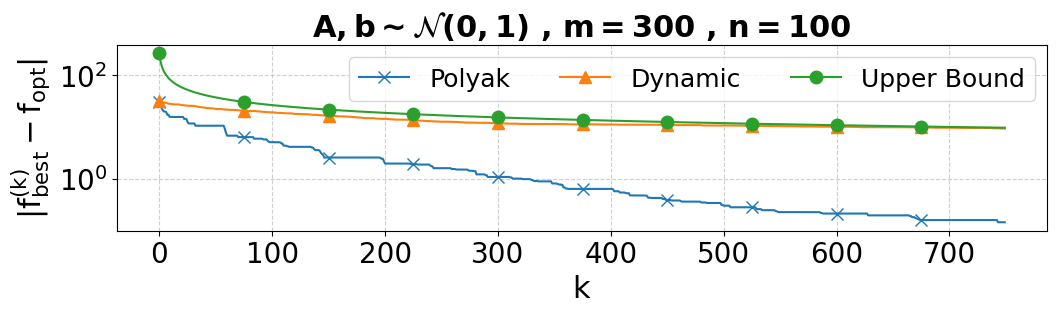

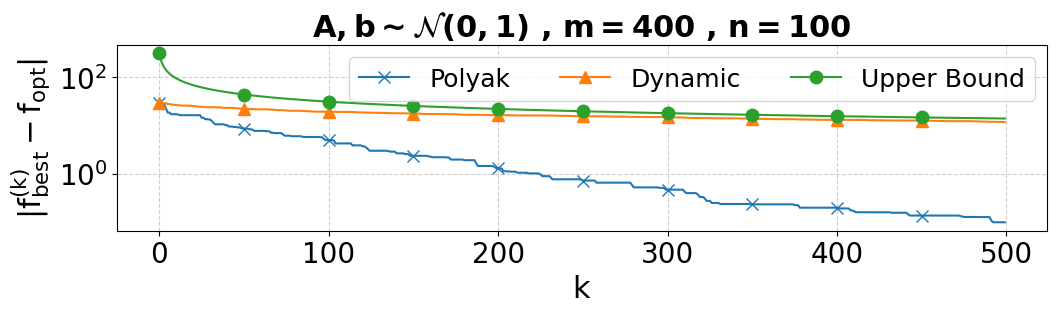

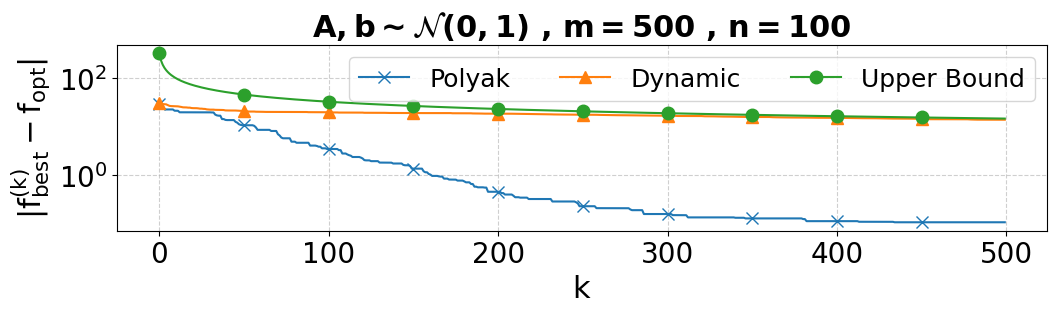

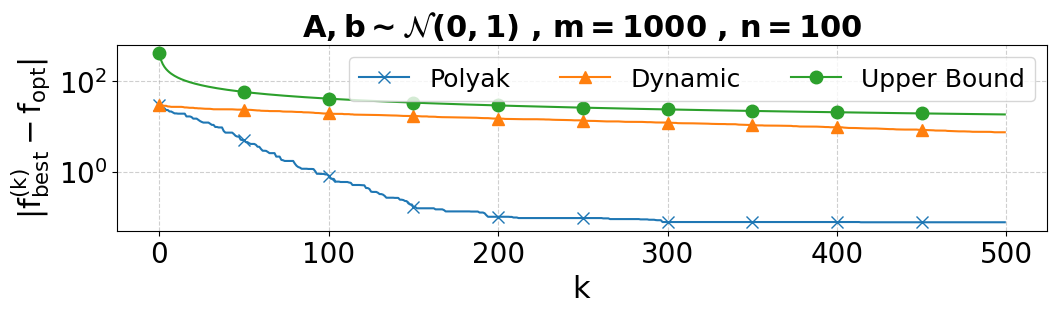

In [15]:
#for m, n in [[100, 100], [300, 100], [700, 100]]:
for m, n, max_k in [[300, 100, 750], [400, 100, 500], [500, 100, 500], [1000, 100, 500]]:

    A, b = create_gaussian_prob(m, n)

    x_star, f_opt = cvx_sol(A, b)
    
    L_f = sqrt( max(np.linalg.eigvals(A.T @ A)))
    dist = np.linalg.norm(np.zeros(n) - x_star)
    bound = L_f * dist / np.sqrt(np.arange(max_k) + 1)

    dynamic_diffs = subgrad_descent(A, b, 'dynamic', f_opt, max_k=max_k)
    polyak_diffs = subgrad_descent(A, b, 'polyak', f_opt, max_k=max_k)
    #polyak_diffs = subgrad_descent(A, b, 'polyak', f_opt, max_k=max_k)

    pdf = PdfPages(f'plots/2.8_vs_N_{m}_{n}.pdf')
    plt.figure(figsize=(12, 3))

    markevery=len(polyak_diffs)//10
    plt.plot(range(len(polyak_diffs)), polyak_diffs, label='Polyak', marker='x', ms=9, markevery=markevery)
    plt.plot(range(len(dynamic_diffs)), dynamic_diffs, label='Dynamic', marker='^', ms=9, markevery=markevery)
    plt.plot(range(len(dynamic_diffs)), bound, label='Upper Bound', marker='o', ms=9, markevery=markevery)

    plt.grid(True, linestyle='--', alpha=0.6)

    plt.legend(ncols=3)

    # Label the axes
    plt.xlabel('$k$')
    plt.ylabel('$|f^{(k)}_{best} - f_{opt}|$')

    #plt.xscale('log')
    plt.yscale('log')

    d = '$A, b \\sim \\mathcal{N}(0, 1)$'
    plt.title(f"{d} , $m = {m}$ , $n = {n}$")

    plt.subplots_adjust(bottom=0.23, top=0.85)

    pdf.savefig(plt.gcf()) # Save the current figure
    plt.show()
    plt.close()
    pdf.close()

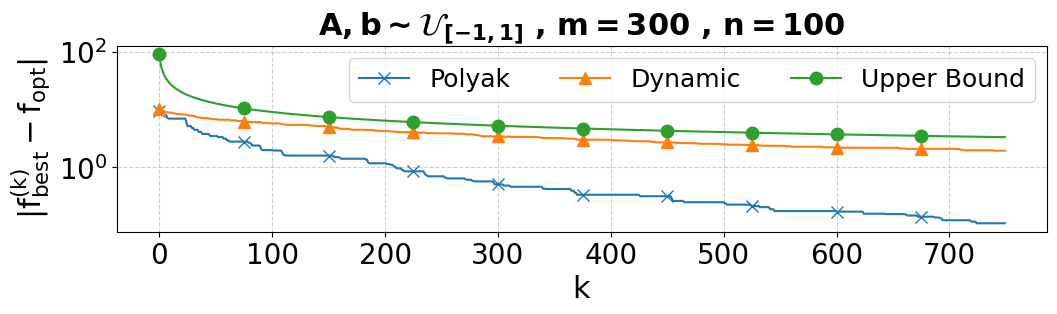

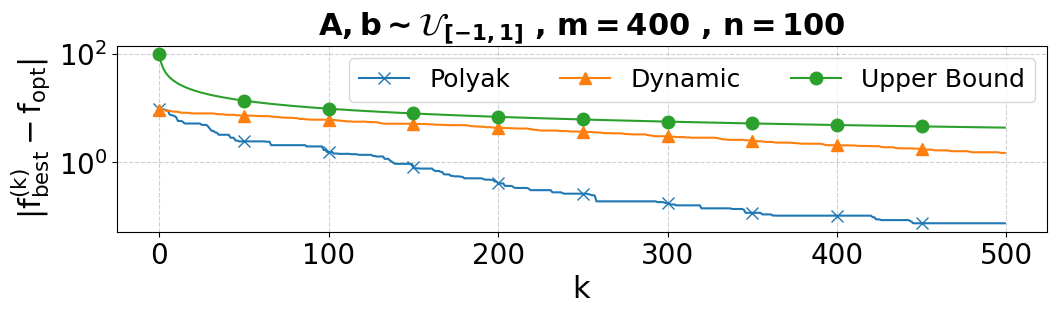

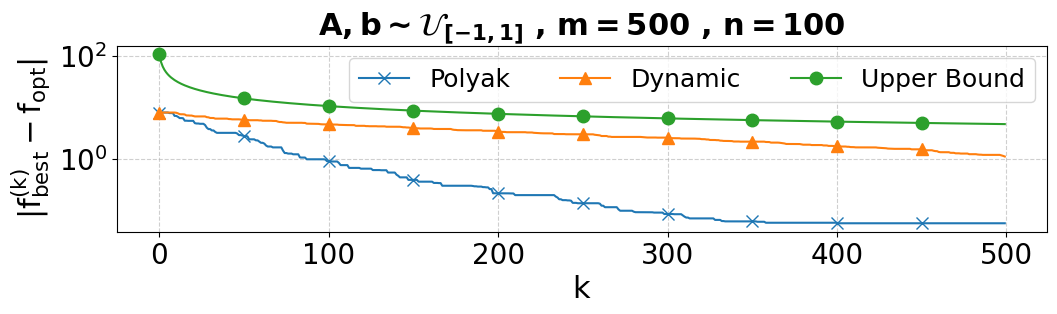

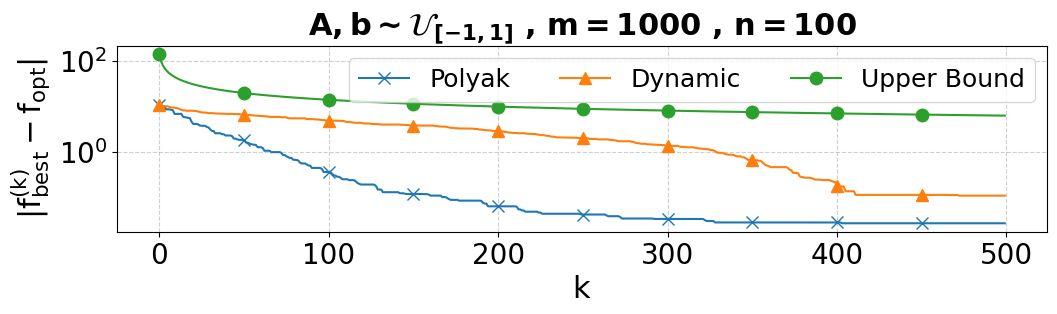

In [16]:
#for m, n in [[100, 100], [300, 100], [700, 100]]:
for m, n, max_k in [[300, 100, 750], [400, 100, 500], [500, 100, 500], [1000, 100, 500]]:

    A, b = create_uniform_prob(m, n)

    x_star, f_opt = cvx_sol(A, b)
    
    L_f = sqrt( max(np.linalg.eigvals(A.T @ A)))
    dist = np.linalg.norm(np.zeros(n) - x_star)
    bound = L_f * dist / np.sqrt(np.arange(max_k) + 1)

    dynamic_diffs = subgrad_descent(A, b, 'dynamic', f_opt, max_k=max_k)
    polyak_diffs = subgrad_descent(A, b, 'polyak', f_opt, max_k=max_k)
    #polyak_diffs = subgrad_descent(A, b, 'polyak', f_opt, max_k=max_k)

    pdf = PdfPages(f'plots/2.8_vs_U_{m}_{n}.pdf')
    plt.figure(figsize=(12, 3))

    markevery=len(polyak_diffs)//10
    plt.plot(range(len(polyak_diffs)), polyak_diffs, label='Polyak', marker='x', ms=9, markevery=markevery)
    plt.plot(range(len(dynamic_diffs)), dynamic_diffs, label='Dynamic', marker='^', ms=9, markevery=markevery)
    plt.plot(range(len(dynamic_diffs)), bound, label='Upper Bound', marker='o', ms=9, markevery=markevery)

    plt.grid(True, linestyle='--', alpha=0.6)

    plt.legend(ncols=3)

    # Label the axes
    plt.xlabel('$k$')
    plt.ylabel('$|f^{(k)}_{best} - f_{opt}|$')

    #plt.xscale('log')
    plt.yscale('log')

    d = '$A, b \\sim \\mathcal{U}_{[-1, 1]}$'
    plt.title(f"{d} , $m = {m}$ , $n = {n}$")

    plt.subplots_adjust(bottom=0.23, top=0.85)

    pdf.savefig(plt.gcf()) # Save the current figure
    plt.show()
    plt.close()
    pdf.close()